#Data Analytic Programming Project
####Group Members
1. Goe Jie Ying A23CS0224
2. Lam Yoke Yu A23CS0233
3. Ling Yu Qian A23CS0301
4. Teh Ru Qian A23CS0191

####Video Links
https://drive.google.com/file/d/1GgiXZk_0Vdi9iRfrhTcIni43FECl0Fkt/view?usp=drive_link

In [ ]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

##**Load and match data.**
#####This session is about insert the csv files into the google colab to load the data for data preparation, and match two csv files based on variable fuel model and maker variable.

##Step 1: Click "Choose Files" button and upload cars_2025.csv and FuelConsumption.csv

In [ ]:
# Upload the cars_2025.csv and FuelConsumption.csv
from google.colab import files
uploaded = files.upload()

Saving cars_2025.csv to cars_2025.csv
Saving FuelConsumption.csv to FuelConsumption.csv


In [ ]:
# Load the uploaded CSV files
cars_df = pd.read_csv('cars_2025.csv')
fuel_df = pd.read_csv('FuelConsumption.csv')

## Step 2: Match datasets

Match vehicle data from `cars_2025.csv` with fuel consumption data from `FuelConsumption.csv` by joining on standardized `maker`, `model`, and mapped `fuel` values using a custom fuel type mapping (`fuel_map`). This ensures more accurate matches by accounting for vehicles that support multiple fuel types, such as petrol models using either regular (`Z`) or premium (`X`) gasoline.



In [ ]:
unique_values = cars_df['fuel'].unique()

print(unique_values)

['electric' 'greendiesel' 'petrol' 'hybrid_petrol' 'diesel'
 'hybrid_diesel']


### Fuel to FUELTYPE Mapping:

| `fuel` (cars\_2025.csv) | `FUELTYPE` (FuelConsumption.csv) |
| ----------------------- | -------------------------------- |
| petrol                  | Z, X                             |
| diesel                  | D                                |
| greendiesel             | D                                |
| electric                | E                                |
| hybrid\_petrol          | Z, X, E                          |
| hybrid\_diesel          | D                                |

After mapping, the `fuel` column is expanded to match all possible `FUELTYPE` codes before performing the join.

In [ ]:
# Normalize text casing and strip whitespace to avoid error
cars_df['maker'] = cars_df['maker'].str.upper().str.strip()
cars_df['model'] = cars_df['model'].str.upper().str.strip()
cars_df['fuel'] = cars_df['fuel'].str.lower().str.strip()

fuel_df['MAKE'] = fuel_df['MAKE'].str.upper().str.strip()
fuel_df['MODEL'] = fuel_df['MODEL'].str.upper().str.strip()
fuel_df['FUELTYPE'] = fuel_df['FUELTYPE'].str.upper().str.strip()

fuel_map = {
    'petrol': ['Z', 'X'],
    'diesel': ['D'],
    'greendiesel': ['D'],
    'electric': ['E'],
    'hybrid_petrol': ['Z', 'X', 'E'],
    'hybrid_diesel': ['D'],
}

# Add new column FUELTYPE, and map each 'fuel' value to a list of possible FUELTYPE codes (e.g., 'petrol' → ['Z', 'X'])
cars_df['FUELTYPE'] = cars_df['fuel'].map(fuel_map)

# Expand the list of FUELTYPEs into separate rows so each row has only one FUELTYPE (needed for accurate join later in merged_df)
cars_df = cars_df.explode('FUELTYPE')

# Join on maker, model, and fueltype
merged_df = pd.merge(
    cars_df,
    fuel_df,
    left_on=['maker', 'model', 'FUELTYPE'],
    right_on=['MAKE', 'MODEL', 'FUELTYPE'],
    how='inner'
)

# Drop the duplicate columns (maker and model)
merged_df = merged_df.drop(columns=['MAKE', 'MODEL', 'fuel'])

# Preview the result (in python)
# print(merged_df.head())

# For preview purpose (Use IPython for better preview)
from IPython.display import display
display(merged_df.head())

# Check number of rows and columns
merged_df.shape

,date_reg,type,maker,model,colour,state,FUELTYPE,MODELYEAR,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2025-01-01,motokar,PORSCHE,911 CARRERA,grey,Johor,Z,2014,MINICOMPACT,3.4,6,AM7,11.6,8.3,10.1,28,232
1,2025-01-01,motokar,PORSCHE,911 CARRERA,grey,Johor,Z,2014,MINICOMPACT,3.4,6,M7,12.5,8.6,10.7,26,246
2,2025-01-02,motokar,HONDA,CIVIC,white,Selangor,X,2014,COMPACT,1.8,4,AV,7.9,6.0,7.0,40,161
3,2025-01-02,motokar,HONDA,CIVIC,white,Selangor,X,2014,COMPACT,1.8,4,AV7,8.1,6.2,7.2,39,166
4,2025-01-02,motokar,HONDA,CIVIC,white,Selangor,X,2014,COMPACT,1.8,4,M5,8.5,6.6,7.6,37,175


(25813, 17)

##**Data cleaning, preparation and wrangling.**
#####This session is about preparing a dataset by handling missing data, duplicates, incorrect data types, and outliers. The goal is to clean the data so that it is ready for further analysis or modeling.

##Step 1: Check for missing data
Identify and count the missing values for each column in the dataset. This helps to determine if any data preprocessing is required for handling missing values.

In [ ]:
missing_data = merged_df.isnull().sum()

##Step 2: Remove duplicates

Check for and remove rows where all column values are identical, ensuring that the dataset only contains unique entries.

In [ ]:
merged_df_cleaned = merged_df.drop_duplicates()

##Step 3: Check data types and convert if necessary

Verify the data types of each column to ensure they are appropriate. If necessary, convert them to the correct type, for example,converting strings to dates or numbers.

In [ ]:
data_types = merged_df_cleaned.dtypes

##Step 4: Handle outliers - Identify outliers using IQR (Interquartile Range)

The IQR is calculated to identify the range of typical values. Outliers are any values outside of 1.5 times the IQR from the first and third quartiles, and these outliers need to be identified for further treatment.

In [ ]:
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Identify outliers in relevant columns
fuel_city_outliers, city_lower, city_upper = identify_outliers(merged_df_cleaned, 'FUELCONSUMPTION_CITY')
fuel_hwy_outliers, hwy_lower, hwy_upper = identify_outliers(merged_df_cleaned, 'FUELCONSUMPTION_HWY')
co2_emissions_outliers, co2_lower, co2_upper = identify_outliers(merged_df_cleaned, 'CO2EMISSIONS')


##Step 5: Remove outliers
 After identifying the outliers, the dataset is filtered to keep only the rows where values fall within the valid range (between the calculated lower and upper bounds). This helps in eliminating extreme values that could distort the analysis.

In [ ]:
merged_df_cleaned = merged_df_cleaned[
    (merged_df_cleaned['FUELCONSUMPTION_CITY'] >= city_lower) & (merged_df_cleaned['FUELCONSUMPTION_CITY'] <= city_upper) &
    (merged_df_cleaned['FUELCONSUMPTION_HWY'] >= hwy_lower) & (merged_df_cleaned['FUELCONSUMPTION_HWY'] <= hwy_upper) &
    (merged_df_cleaned['CO2EMISSIONS'] >= co2_lower) & (merged_df_cleaned['CO2EMISSIONS'] <= co2_upper)
]

# Directly show the first few rows of the cleaned merged dataset
display(merged_df_cleaned.head())

# Check number of rows and columns left
merged_df_cleaned.shape

,date_reg,type,maker,model,colour,state,FUELTYPE,MODELYEAR,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2025-01-01,motokar,PORSCHE,911 CARRERA,grey,Johor,Z,2014,MINICOMPACT,3.4,6,AM7,11.6,8.3,10.1,28,232
1,2025-01-01,motokar,PORSCHE,911 CARRERA,grey,Johor,Z,2014,MINICOMPACT,3.4,6,M7,12.5,8.6,10.7,26,246
2,2025-01-02,motokar,HONDA,CIVIC,white,Selangor,X,2014,COMPACT,1.8,4,AV,7.9,6.0,7.0,40,161
3,2025-01-02,motokar,HONDA,CIVIC,white,Selangor,X,2014,COMPACT,1.8,4,AV7,8.1,6.2,7.2,39,166
4,2025-01-02,motokar,HONDA,CIVIC,white,Selangor,X,2014,COMPACT,1.8,4,M5,8.5,6.6,7.6,37,175


(7902, 17)

##Data Aggregation and Group Operations
#####This section focuses on using data aggregation and group-based computations to derive useful insights from the cleaned dataset. The aim is to analyze fuel consumption patterns, emission statistics and registration statistics categorized by different attributes.

###1. Average CO2 Emissions by Car Maker
#####The dataset is grouped by car maker to calculate the average carbon dioxide (CO2) emissions produced by vehicles. This aggregation helps identify which car makers contribute more significantly to CO2 emissions, providing insight into their environmental impact. The results are sorted in descending order to highlight the highest.

        maker  CO2EMISSIONS
0       DODGE    258.000000
1       VOLVO    257.320388
2  VOLKSWAGEN    255.210900
3     HYUNDAI    247.446154
4        FORD    246.290323


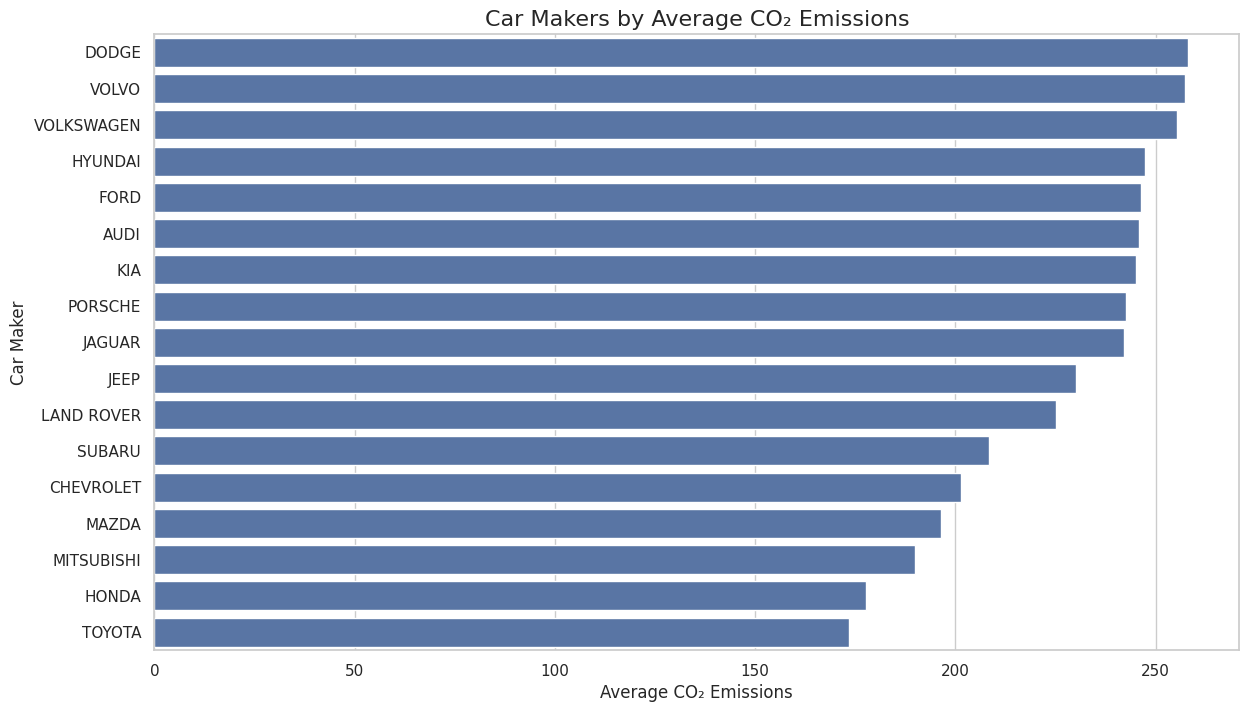

In [ ]:
# Average CO2 emissions by car maker
avg_co2_by_maker = merged_df_cleaned.groupby('maker')['CO2EMISSIONS'].mean().sort_values(ascending=False).reset_index()

print(avg_co2_by_maker.head())

# Visualisation
sns.set(style="whitegrid")
plt.figure(figsize=(14, 8))
sns.barplot(
    data=avg_co2_by_maker,
    x='CO2EMISSIONS',
    y='maker',
)

plt.title('Car Makers by Average CO₂ Emissions', fontsize=16)
plt.xlabel('Average CO₂ Emissions', fontsize=12)
plt.ylabel('Car Maker', fontsize=12)
plt.show()

###2. Total Car Registrations by Car Model
#####The dataset is grouped by both car maker and model to determine the number of times each vehicle model appears in the registration records. This aggregation provides insight into the popularity of specific vehicle models. The grouped data is then sorted in descending order based on registration count to identify the most commonly registered models.

        maker   model  registration_count
0       HONDA   CIVIC                2826
1       MAZDA    CX-5                1458
2      TOYOTA   YARIS                 974
3       HONDA    CR-V                 761
4  VOLKSWAGEN  TIGUAN                 410


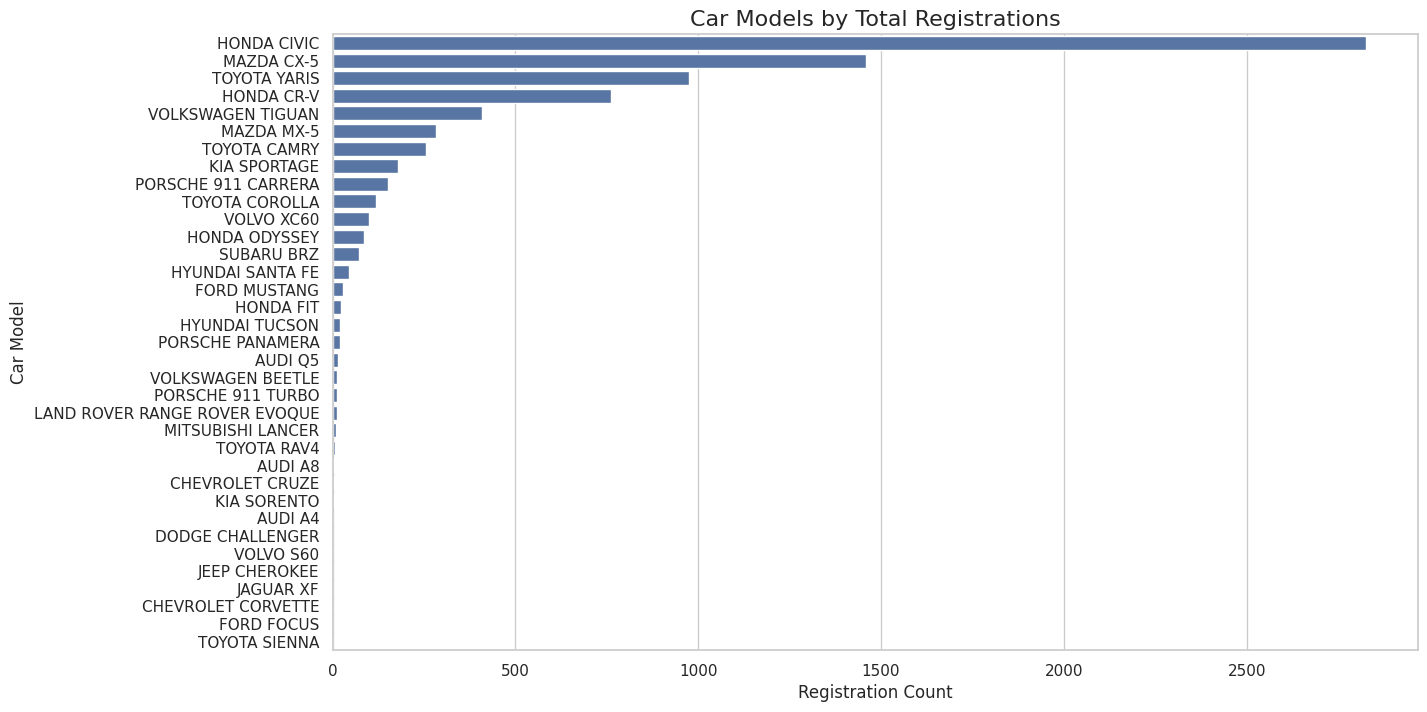

In [ ]:
# Total car registrations by model
registrations_by_model = merged_df_cleaned.groupby(['maker','model']).size().reset_index(name='registration_count')
registrations_by_model = registrations_by_model.sort_values(by='registration_count', ascending=False)
registrations_by_model = registrations_by_model.reset_index(drop=True)

print(registrations_by_model.head())

# Visualisation
registrations_by_model_copy = registrations_by_model.copy()
registrations_by_model_copy['maker_model'] = registrations_by_model['maker'] + ' ' + registrations_by_model['model']

plt.figure(figsize=(14, 8))
barplot = sns.barplot(
    data=registrations_by_model_copy,
    y='maker_model',
    x='registration_count'
)

plt.title('Car Models by Total Registrations', fontsize=16)
plt.xlabel('Registration Count', fontsize=12)
plt.ylabel('Car Model', fontsize=12)
plt.show()

###3. Average Fuel Consumption by Fuel Type
#####The dataset is grouped by fuel type to calculate the average fuel consumption in city, highway and combined driving conditions. This analysis provides a comparative view of the efficiency of different fuel types. By evaluating fuel consumption across these categories, insights can be gained into which fuel types are more economical or environmentally friendly in various driving conditions.

  FUELTYPE  FUELCONSUMPTION_CITY  FUELCONSUMPTION_HWY  FUELCONSUMPTION_COMB
0        X              8.944766             6.836929              7.977660
1        Z             11.912982             8.767241             10.494625


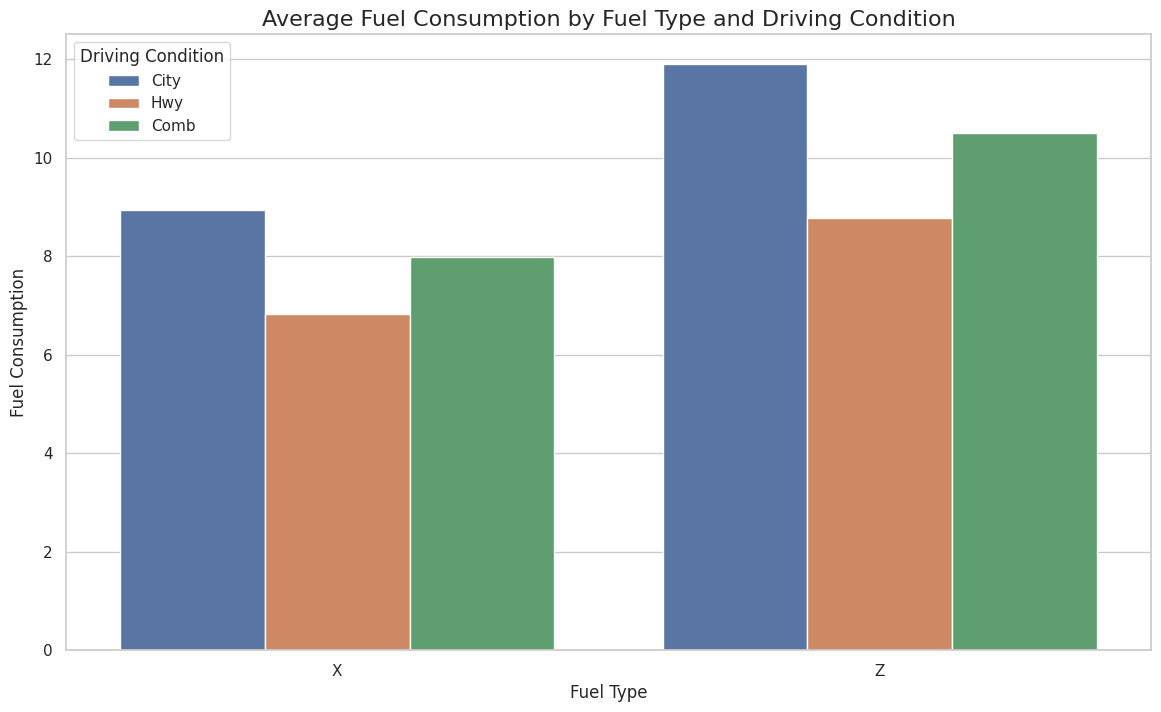

In [ ]:
# Average fuel consumption by fuel type
avg_fuel_by_type = None
if 'FUELTYPE' in merged_df_cleaned.columns:
  avg_fuel_by_type = merged_df_cleaned.groupby('FUELTYPE')[['FUELCONSUMPTION_CITY', 'FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB']].mean().reset_index()

print(avg_fuel_by_type)

# Viusalisation
avg_fuel_melted = avg_fuel_by_type.melt(
    id_vars='FUELTYPE',
    value_vars=['FUELCONSUMPTION_CITY', 'FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB'],
    var_name='Condition',
    value_name='Average Fuel Consumption'
)

avg_fuel_melted['Condition'] = avg_fuel_melted['Condition'].str.replace('FUELCONSUMPTION_', '', regex=False).str.title()

plt.figure(figsize=(14, 8))
sns.barplot(
    data=avg_fuel_melted,
    x='FUELTYPE',
    y='Average Fuel Consumption',
    hue='Condition',
)

plt.title('Average Fuel Consumption by Fuel Type and Driving Condition', fontsize=16)
plt.xlabel('Fuel Type', fontsize=12)
plt.ylabel('Fuel Consumption', fontsize=12)
plt.legend(title='Driving Condition')
plt.show()

###4. Average CO2 Emissions by Fuel Type
#####The dataset is grouped by fuel type to compute the average carbon dioxide (CO2) emissions associated with each fuel category. This aggregation allows for comparison between different fuel types in terms of their environmental impact. The results are sorted in descending order to highlight the fuel types contributing the most to CO2 emissions.

  FUELTYPE  CO2EMISSIONS
0        Z    241.484787
1        X    183.583719


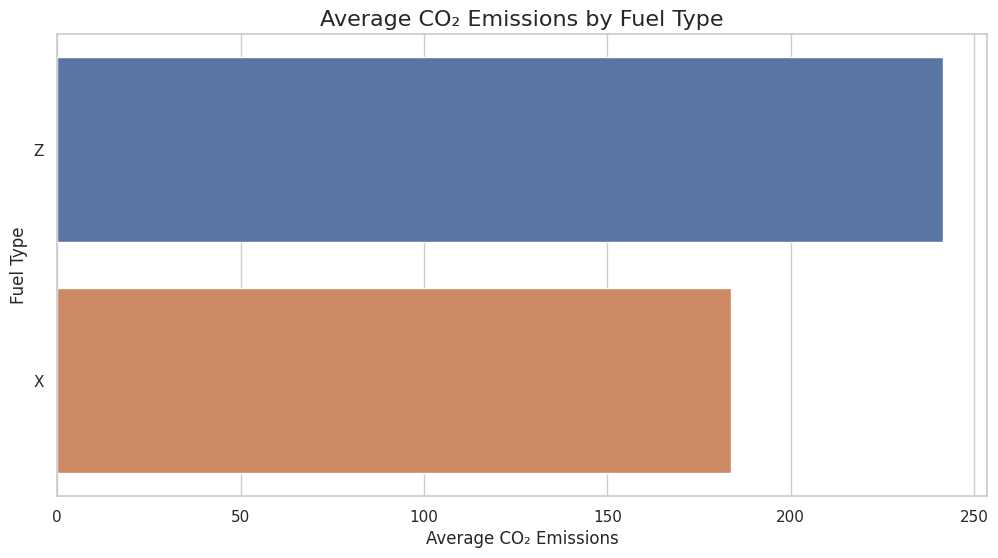

In [ ]:
# CO2 emissions by fuel type
co2_by_fuel_type = None
if 'FUELTYPE' in merged_df_cleaned.columns:
  co2_by_fuel_type = merged_df_cleaned.groupby('FUELTYPE')['CO2EMISSIONS'].mean().sort_values(ascending=False).reset_index()

print(co2_by_fuel_type)

# Visualisation
plt.figure(figsize=(12, 6))
sns.barplot(
    data=co2_by_fuel_type,
    x='CO2EMISSIONS',
    y='FUELTYPE',
    hue='FUELTYPE'
)

plt.title('Average CO₂ Emissions by Fuel Type', fontsize=16)
plt.xlabel('Average CO₂ Emissions', fontsize=12)
plt.ylabel('Fuel Type', fontsize=12)
plt.show()

###5. Top 5 Most Polluting Vehicle Models
#####The dataset is sorted in descending order based on carbon dioxide (CO2) emissions to identify vehicle models with the highest emission levels. Duplicate entries are removed to ensure each model appears only once in the ranking. The top five car models that release the most CO2 are highlighted in this analysis, assisting in identifying serious environmental those who violate.

        maker      model  CO2EMISSIONS
0     PORSCHE  911 TURBO           274
1  VOLKSWAGEN     TIGUAN           267
2        FORD    MUSTANG           264
3         KIA    SORENTO           262
4         KIA   SPORTAGE           260


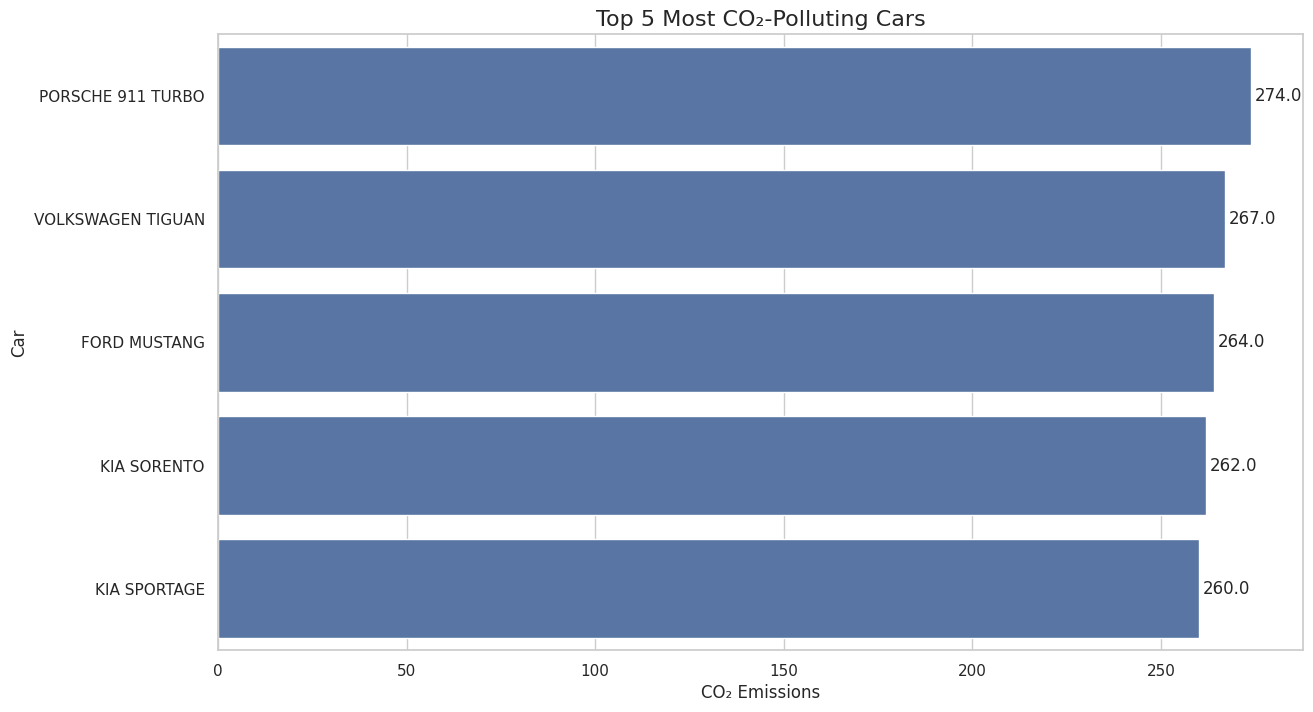

In [ ]:
# Top 5 most polluting models
top_polluters = merged_df_cleaned[['maker', 'model', 'CO2EMISSIONS']].sort_values(by='CO2EMISSIONS', ascending=False).drop_duplicates()
top_polluters = top_polluters.reset_index(drop=True)

print(top_polluters.head(5))

# Visualisation
top_polluters_copy = top_polluters.head(5).copy()
top_polluters_copy['Car'] = top_polluters_copy['maker'] + ' ' + top_polluters_copy['model']

plt.figure(figsize=(14, 8))
sns.barplot(
    data=top_polluters_copy,
    x='CO2EMISSIONS',
    y='Car'
)

plt.title('Top 5 Most CO₂-Polluting Cars', fontsize=16)
plt.xlabel('CO₂ Emissions', fontsize=12)
plt.ylabel('Car', fontsize=12)

for index, row in top_polluters_copy.iterrows():
    plt.text(row.CO2EMISSIONS + 1, index, f"{row.CO2EMISSIONS:.1f}", va='center')

plt.show()

###6. Emission Category Distribution
#####The vehicles are categorized into four emission levels: Low, Moderate, High and Very High—based on their CO2 emission values using defined numeric bins. The count of vehicles in each emission category is then calculated to understand the distribution of environmental impact across the dataset. This grouping aids in evaluating how many vehicles fall into each emission severity level.

  Emission Category  Count
0          Moderate   5581
1              High   1822
2         Very High    499
3               Low      0


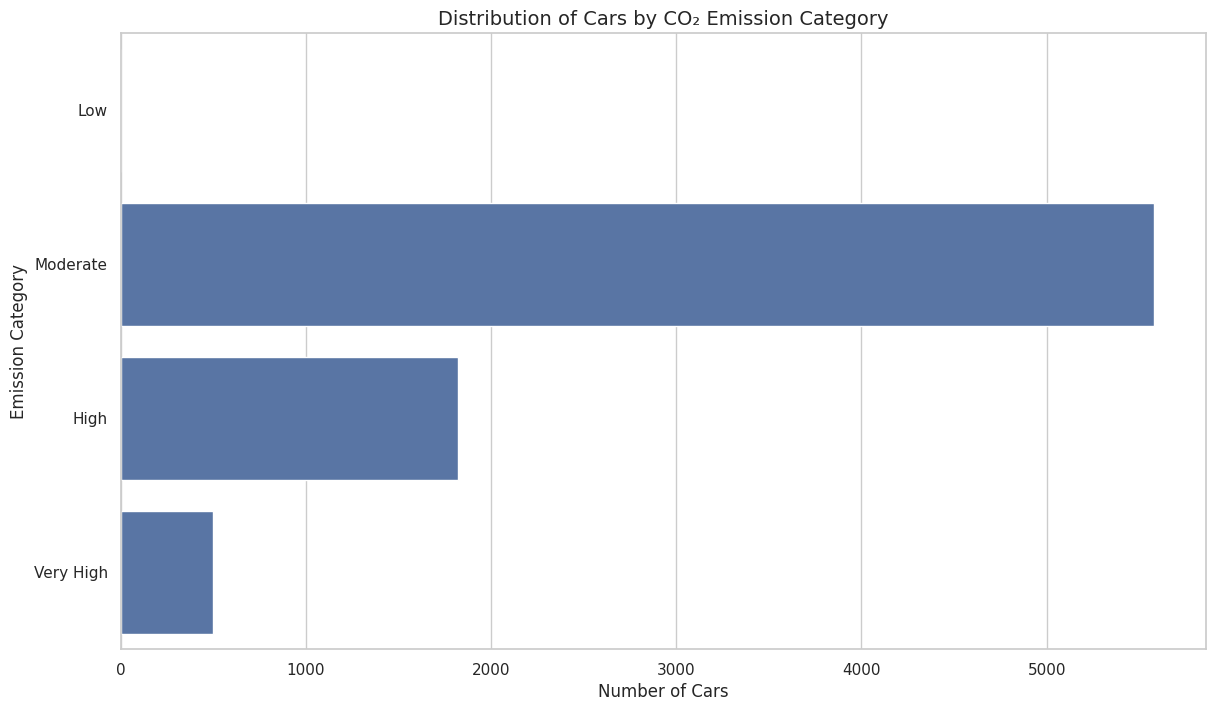

In [ ]:
#Emission category counts
merged_df_cleaned['EMISSION_CATEGORY'] = pd.cut(
    merged_df_cleaned['CO2EMISSIONS'],
    bins=[0, 150, 200, 250, 1000],
    labels=['Low', 'Moderate', 'High', 'Very High']
)
emission_category_counts = merged_df_cleaned['EMISSION_CATEGORY'].value_counts().reset_index()
emission_category_counts.columns = ['Emission Category', 'Count']

#For preview purpose
print(emission_category_counts)

# Visualisation
plt.figure(figsize=(14, 8))
sns.barplot(
    data=emission_category_counts,
    x='Count',
    y='Emission Category'
)

plt.title('Distribution of Cars by CO₂ Emission Category', fontsize=14)
plt.xlabel('Number of Cars')
plt.ylabel('Emission Category')
plt.show()

## Summary Analytics

In [ ]:
# Descriptive Statistics
merged_df_cleaned.describe()

,MODELYEAR,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
count,7902.0,7902.000000,7902.000000,7902.000000,7902.000000,7902.000000,7902.000000,7902.000000
mean,2014.0,2.058036,4.153632,9.315135,7.077790,8.291724,34.702987,190.808529
std,0.0,0.494722,0.544151,1.596545,0.975038,1.316965,4.896937,30.281971
min,2014.0,1.400000,4.000000,7.800000,5.900000,7.000000,24.000000,161.000000
25%,2014.0,1.800000,4.000000,8.100000,6.300000,7.200000,31.000000,166.000000
50%,2014.0,2.000000,4.000000,8.900000,6.600000,8.000000,35.000000,184.000000
75%,2014.0,2.400000,4.000000,10.300000,7.600000,9.100000,39.000000,209.000000
max,2014.0,6.200000,8.000000,13.700000,9.600000,11.900000,40.000000,274.000000


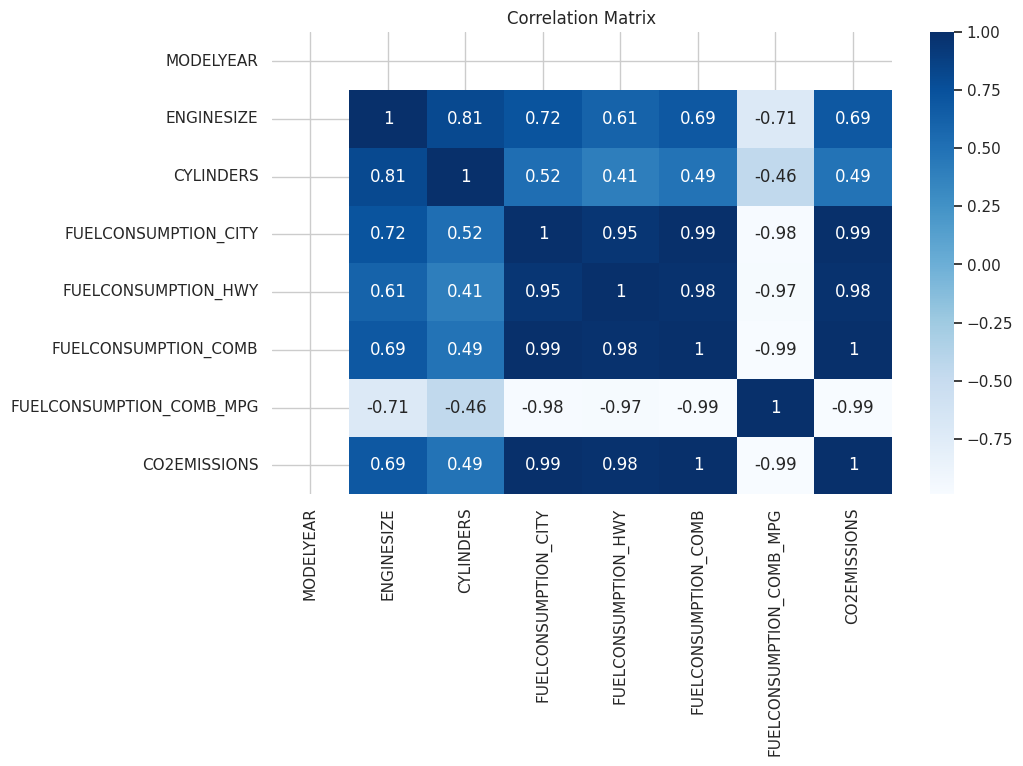

In [ ]:
# Correlation Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(merged_df_cleaned.corr(numeric_only=True), annot=True, cmap='Blues')
plt.title("Correlation Matrix")
plt.show()

Based on the correlation matrix, we can deduce that the number of cylinders has less impact on fuel consumption compared to engine size. Additionally, fuel consumption in the city and on the highway is highly correlated. Since combined fuel consumption is derived from both city and highway fuel consumption, a high correlation among them is expected. Similarly, FUELCONSUMPTION_COMB_MPG, which represents combined fuel consumption in miles per gallon, is calculated based on the combined fuel consumption in liters per 100 kilometers. Therefore, a strong negative correlation is observed. Finally, CO₂ emissions are directly proportional to combined fuel consumption, which explains the correlation of 1.

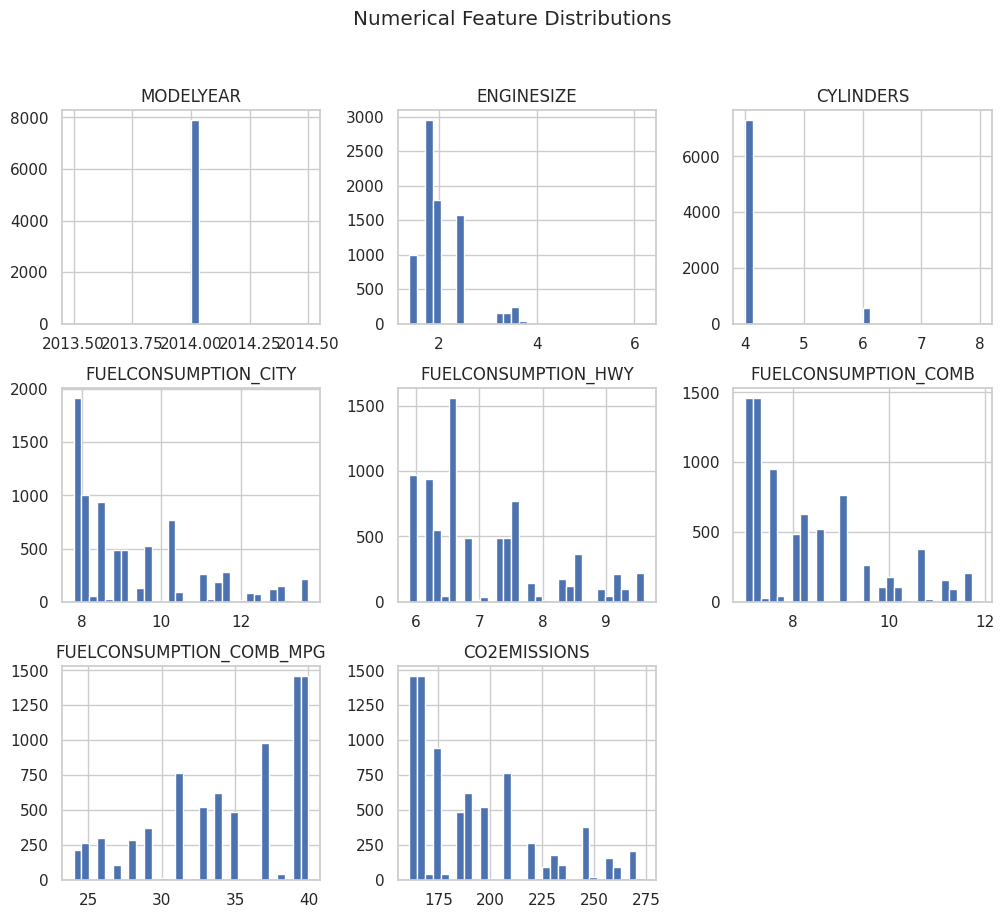

In [ ]:
# Numerical Feature Distribution
numeric_columns = merged_df_cleaned.select_dtypes(include=[np.number]).columns
merged_df_cleaned[numeric_columns].hist(figsize=(12, 10), bins=30)
plt.suptitle("Numerical Feature Distributions")
plt.show()

Based on the distribution, we can observe that ENGINESIZE, CYLINDERS, FUELCONSUMPTION_CITY, FUELCONSUMPTION_HWY, FUELCONSUMPTION_COMB, and CO2EMISSIONS are all right-skewed. This distribution shape is consistent with the positive correlations observed in the correlation matrix. In contrast, FUELCONSUMPTION_COMB_MPG is left-skewed, which aligns with its negative correlation with the other variables.

## Perform machine learning
1. KMeans (Clustering)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Step 1: Select and scale features
X_cluster = merged_df_cleaned[['CO2EMISSIONS', 'FUELCONSUMPTION_COMB', 'ENGINESIZE']]
X_scaled = StandardScaler().fit_transform(X_cluster)

In [ ]:
# Step 2: PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA components to dataframe
merged_df_cleaned['PCA1'] = X_pca[:, 0]
merged_df_cleaned['PCA2'] = X_pca[:, 1]

In [ ]:
# Step 3: KMeans clustering
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
merged_df_cleaned['cluster_KMeans'] = kmeans.fit_predict(X_scaled)

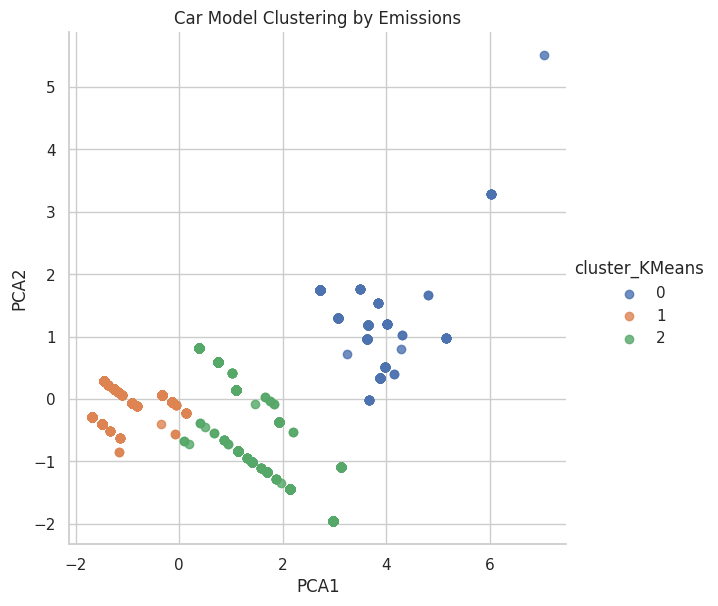

In [ ]:
# Step 4: Visualize clusters
sns.lmplot(x='PCA1', y='PCA2', data=merged_df_cleaned, hue='cluster_KMeans', fit_reg=False, height=6)
plt.title('Car Model Clustering by Emissions')
plt.show()

In [ ]:
# Step 5: Calculate the average CO2 emissions per cluster
cluster_emission_avg = merged_df_cleaned.groupby('cluster_KMeans')['CO2EMISSIONS'].mean().reset_index()
cluster_emission_avg = cluster_emission_avg.sort_values(by='CO2EMISSIONS', ascending=True)

# Show the result
print("Average CO₂ Emissions by Cluster:")
print(cluster_emission_avg)

Average CO₂ Emissions by Cluster:
   cluster_KMeans  CO2EMISSIONS
1               1    171.084189
2               2    219.496590
0               0    242.634518


Using PCA for dimensionality reduction and K-Means (with 3 clusters), the car models were grouped based on emission-related features such as engine size and fuel consumption.

* The clustering result showed clear separation between groups.
* The average CO₂ emissions for each cluster were:
  1. Cluster 0 (Blue) - 242.63 (High)
  2. Cluster 1 (Green) - 219.50 (Moderate)
  3. Cluster 2 (Orange) - 242.63	(Low)

This means Cluster 2 represents low-emission vehicles, Cluster 1 moderate-emission, and Cluster 0 high-emission vehicles. From here, we can identify which car models are more eco-friendly, and which ones produce more CO₂.


2. Random Forest (Classification)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

In [ ]:
# Step 1: Define Emission Category Level
merged_df_cleaned['EMISSION_CATEGORY'] = pd.qcut(
    merged_df_cleaned['CO2EMISSIONS'],
    q=4,
    labels=['Low', 'Moderate', 'High', 'Very High']
)

In [ ]:
# Step 2: Remove rows with missing category
merged_df_cleaned = merged_df_cleaned.dropna(subset=['EMISSION_CATEGORY'])

In [ ]:
# Step 3: Select Features and Label
features = ['FUELCONSUMPTION_COMB', 'ENGINESIZE', 'FUELCONSUMPTION_CITY']
X = merged_df_cleaned[features]
y = merged_df_cleaned['EMISSION_CATEGORY']

In [ ]:
# Step 4: Split into test set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Step 5: Train random forest model
model = RandomForestClassifier(random_state=42)
model.fit(Xtrain, ytrain)

RandomForestClassifier(random_state=42)

In [ ]:
# Step 6: Make prediction
y_pred = model.predict(Xtest)

In [ ]:
# Step 7: Evaluate the performance by calculating the accuracy and classification report
print("Accuracy:", accuracy_score(ytest, y_pred))
print("\nClassification Report:\n", classification_report(ytest, y_pred))

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00       562
         Low       1.00      1.00      1.00       727
    Moderate       1.00      1.00      1.00       591
   Very High       1.00      1.00      1.00       491

    accuracy                           1.00      2371
   macro avg       1.00      1.00      1.00      2371
weighted avg       1.00      1.00      1.00      2371



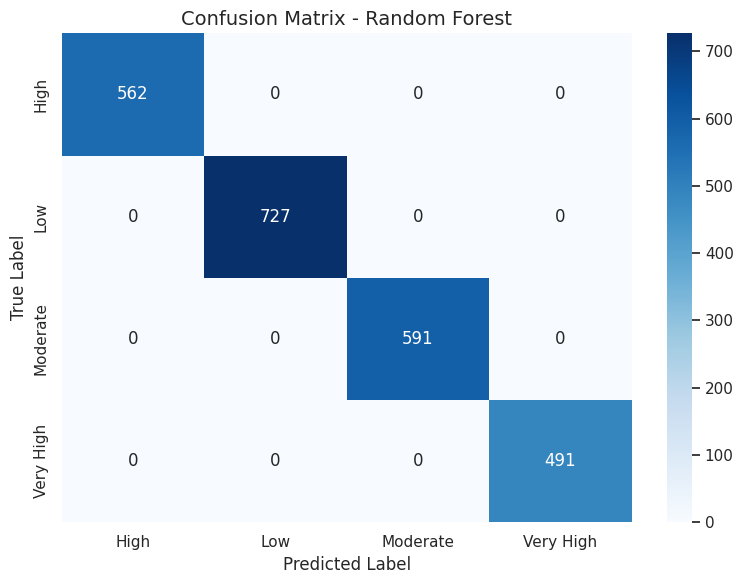

In [ ]:
# Step 8: Confusion Matrix
cm = confusion_matrix(ytest, y_pred, labels=model.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=model.classes_,
    yticklabels=model.classes_
)

plt.title("Confusion Matrix - Random Forest", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

The Random Forest classifier was applied to predict car emission categories (Low, Moderate, High, Very High) based on features like:

*   FUELCONSUMPTION_COMB
*   ENGINESIZE
*   FUELCONSUMPTION_CITY

**Observation:**
1. Achieved 100% accuracy on the test set (2371 samples)

2. Precision, recall, and F1-score are 1.00 across all classes

3. The confusion matrix confirms no misclassification at all

**Conclusion:**
1. The model perfectly learned to distinguish between emission levels

2. These features (especially fuel consumption and engine size) are highly predictive of CO₂ categories

3. Suggests very clean, non-overlapping patterns in the dataset, likely due to strong correlation between input features and emission labels

4. Helps to automatically categorize cars based on how much they pollute
